<a href="https://colab.research.google.com/github/nphmy/OptiChoice-Predict-consumer-demand.ipynb/blob/main/Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

In [ ]:
#Import the data and parse dates.
df  = pd.read_csv('/content/drive/MyDrive/Data chính_DT  - Data chính.csv', parse_dates=['Date'], low_memory=False)

<ipython-input-4-adc5ae0b589e>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df  = pd.read_csv('/content/drive/MyDrive/Data chính_DT  - Data chính.csv', parse_dates=['Date'], low_memory=False)


In [ ]:
df.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_1970,Whse_J,Category_005,2012-02-07,28000
1,Product_1970,Whse_J,Category_005,2012-03-01,4000
2,Product_1970,Whse_J,Category_005,2012-03-22,28000
3,Product_1970,Whse_J,Category_005,2012-03-22,9000
4,Product_1970,Whse_J,Category_005,2012-04-18,4000


In [ ]:
df.shape

(41199, 5)

In [ ]:
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object

In [ ]:
# Check any number of columns with NaN-kiem tra gia tri not a number
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN-1/5 cot co it nhat 1 gia tri not a number, trong do, co 5/ tổng 41199 giá trị not a number
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

1  /  5
22  /  41199


In [ ]:
#Lets check where these nulls are.
print (df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)
#There are missing values in Dates.
#kiểm tra có 22 giá trị trong cột Date, chiếm chưa tới 1% => xóa

Product_Code         0
Warehouse            0
Product_Category     0
Date                22
Order_Demand         0
dtype: int64
Null to Dataset Ratio in Dates:  0.05339935435326101


In [ ]:
#Drop na's.

#Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;)
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
22108,Product_0620,Whse_J,Category_001,2011-12-21,3
21956,Product_0620,Whse_J,Category_001,2011-12-21,3
17705,Product_0620,Whse_J,Category_001,2011-12-21,10
23497,Product_0620,Whse_J,Category_001,2011-12-22,2
23678,Product_0620,Whse_J,Category_001,2011-12-22,2
16498,Product_0620,Whse_J,Category_001,2011-12-22,30
16678,Product_0620,Whse_J,Category_001,2011-12-22,20
1377,Product_0033,Whse_S,Category_005,2011-12-22,15000
23745,Product_0620,Whse_J,Category_001,2011-12-22,2
28015,Product_0620,Whse_J,Category_001,2011-12-22,1


In [ ]:
#Target Feature - Order_Demand
#Removing () from the target feature.

df['Order_Demand'].apply(str).str.replace(',', '')


0        28000
1         4000
2        28000
3         9000
4         4000
         ...  
41194        1
41195        0
41196        0
41197      -84
41198      -98
Name: Order_Demand, Length: 41177, dtype: object

In [ ]:
df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [ ]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()
#There is data for 6 years. great.

(Timestamp('2011-05-31 00:00:00'), Timestamp('2017-01-06 00:00:00'))

In [ ]:
#Lets start with 2012 and cap it 2016 december. Since the dates before 2012 have a lot of missing values - inspected and checked using basic time series plot.
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

<ipython-input-15-ab7bd629c130>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df['Order_Demand'], fit=norm)


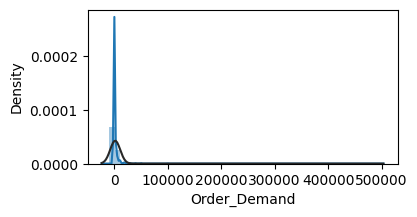

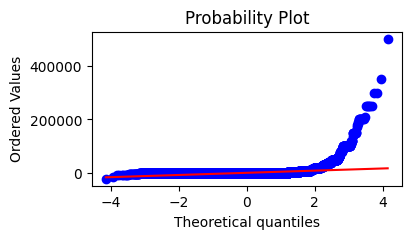

In [ ]:
#Lets check the ditribution of the target variable (Order_Demand) #Hãy kiểm tra phân phối của biến mục tiêu (Nhu cầu đặt hàng)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sb.distplot(df['Order_Demand'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

In [ ]:
#The data is highly skewed, but since we'll be applying ARIMA, it's fine.
df['Order_Demand'].skew()

16.968180874798268

In [ ]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

Whse_J    31575
Whse_A     4128
Whse_S     3454
Whse_C     1971
Name: Warehouse, dtype: int64

In [ ]:
#The amount of orders shipped by each warehouse.
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)
#Warehouse J is clearly shipping most orders. Although S is shipping more quantity within fewer requested orders.

<ipython-input-18-cf501b64a289>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)


,Order_Demand
Warehouse,
Whse_J,35879928
Whse_S,35081205
Whse_A,8189735
Whse_C,2456148


In [ ]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
#This gives us the total orders placed on each day.

In [ ]:
#Index the date
df = df.set_index('Date')
df.index #Lets check the index

DatetimeIndex(['2012-01-02', '2012-01-03', '2012-01-04', '2012-01-05',
               '2012-01-06', '2012-01-08', '2012-01-09', '2012-01-10',
               '2012-01-11', '2012-01-12',
               ...
               '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
               '2016-12-23', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1485, freq=None)

In [ ]:
#Averages daily sales value for the month, and we are using the start of each month as the timestamp.
y = df['Order_Demand'].resample('MS').mean()

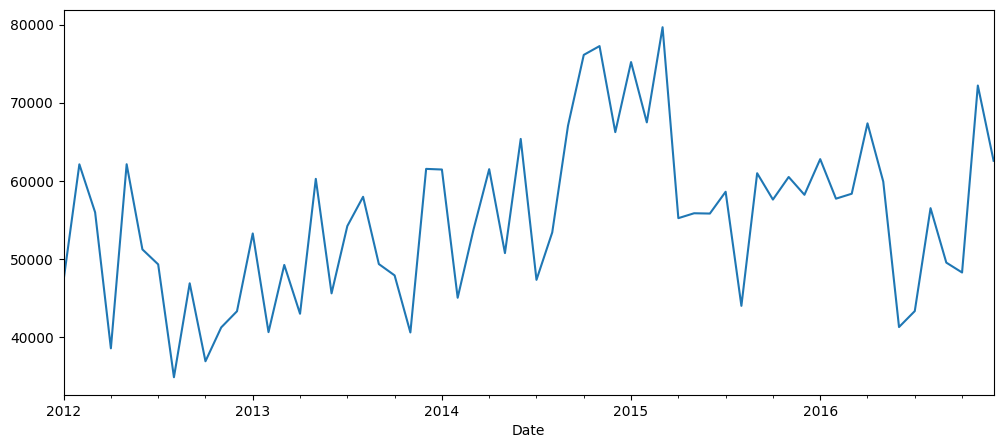

In [ ]:
#Visualizing time series.

y.plot(figsize=(12,5))
plt.show()

#Takeaway: The sales are always low for the beginning of the year and the highest peak in demand every year is in the
#last quarter. The observed trend shows that orders were higher during 2014-2016 then reducing.

#Lets check it by decomposition.

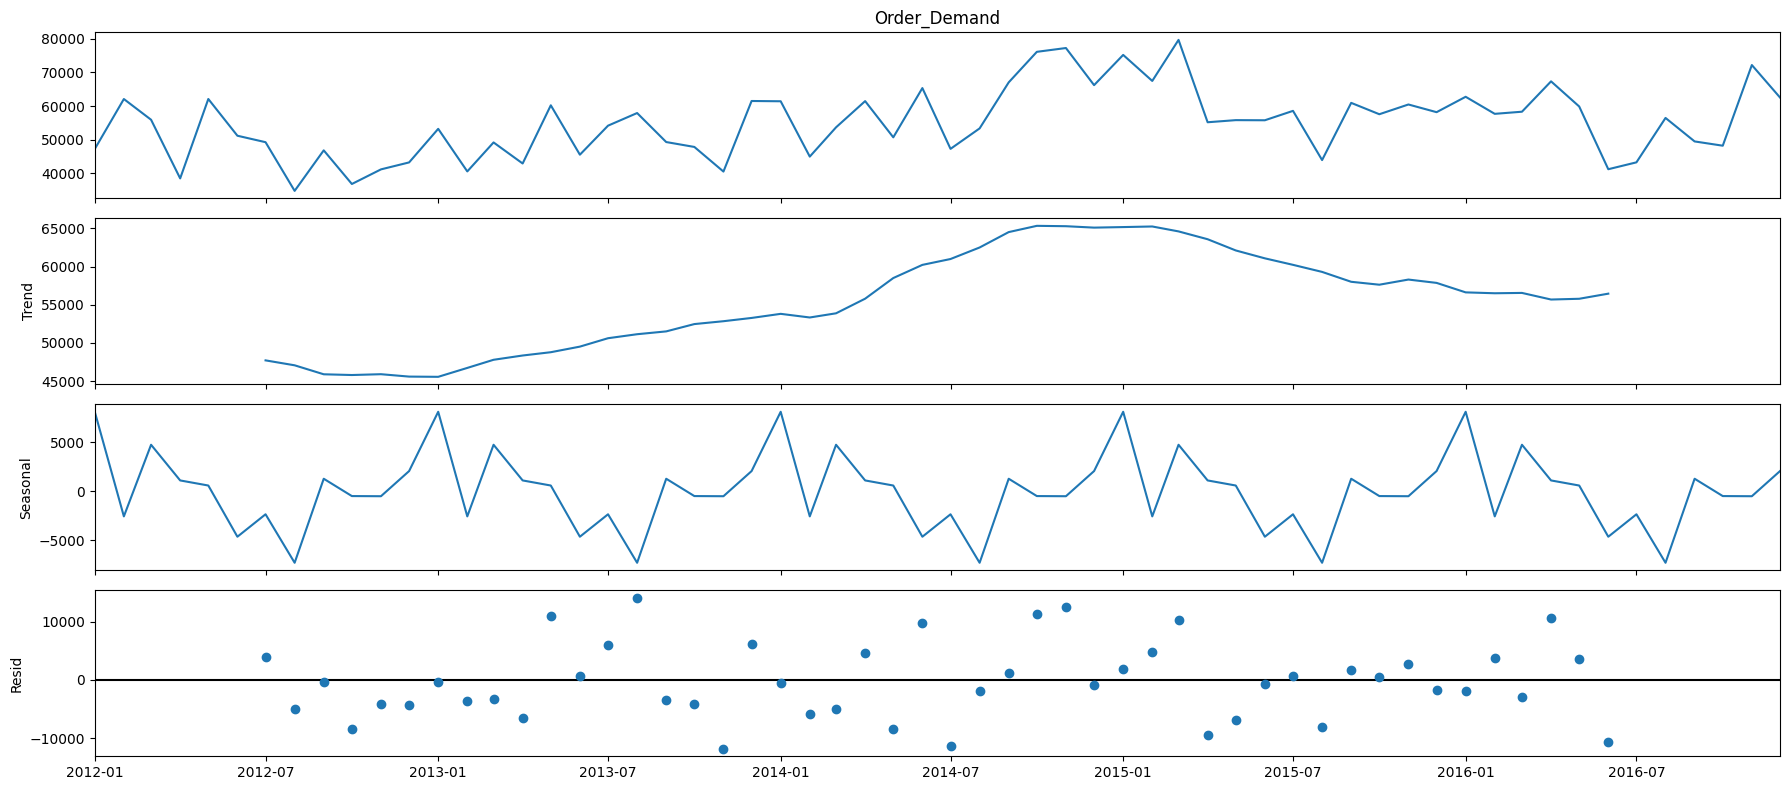

In [ ]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition.
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

print('Examples of parameter combinations for ARIMA...')
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(y, order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue


Examples of parameter combinations for ARIMA...
ARIMA(0, 0, 0) - AIC:1283.969080963413
ARIMA(0, 0, 1) - AIC:1278.9299359884237
ARIMA(0, 1, 0) - AIC:1271.158470517677
ARIMA(0, 1, 1) - AIC:1264.214772070603
ARIMA(1, 0, 0) - AIC:1275.1883382233766
ARIMA(1, 0, 1) - AIC:1271.9240950321969
ARIMA(1, 1, 0) - AIC:1266.9300104590488
ARIMA(1, 1, 1) - AIC:1261.5653935607909


In [ ]:
import pandas as pd
import statsmodels.api as sm

mod = sm.tsa.ARIMA(y,
                   order=(1, 1, 1),
                   enforce_stationarity=False,
                   enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0068      0.193     -0.035      0.972      -0.386       0.372
ma.L1         -0.7142      0.141     -5.058      0.000      -0.991      -0.437
sigma2      8.183e+07   5.67e-10   1.44e+17      0.000    8.18e+07    8.18e+07


In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.9792250215911884
p-value: 0.03688059836241836


In [ ]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2014-05-01'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()
plt.show()


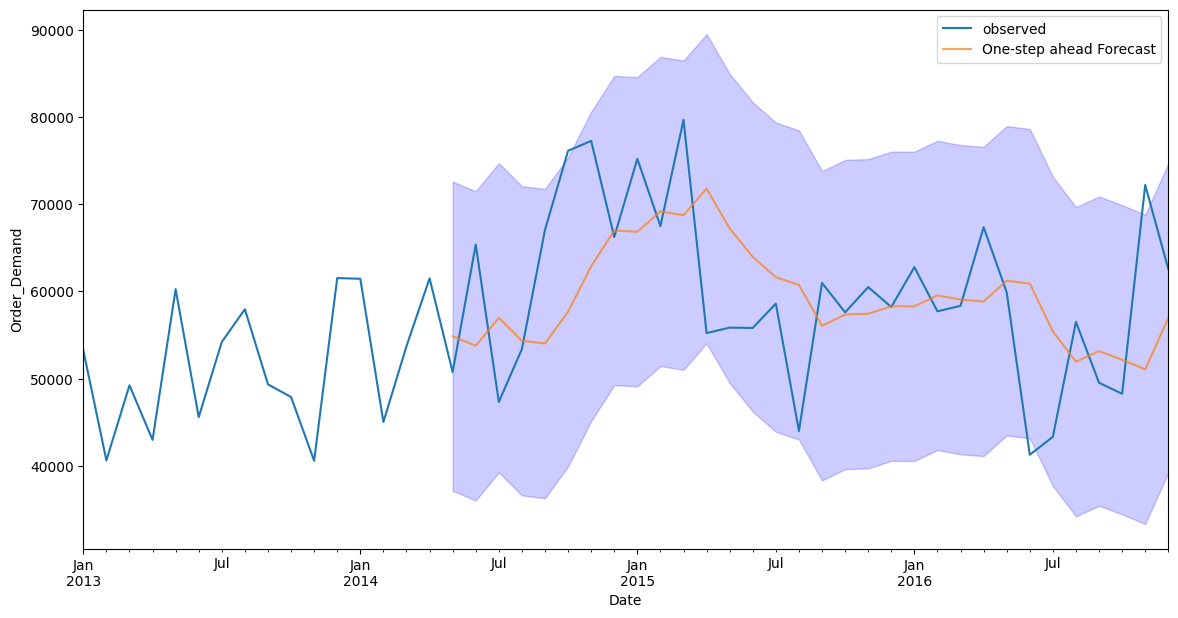

In [ ]:
#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

In [ ]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

In [ ]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Far out values are naturally more prone to variance. The grey area is the confidence we have in the predictions.